# Grounding DINO 模型评估对比

本 notebook 用于对比评估：
1. 原始预训练的 Grounding DINO 模型
2. 微调后的 Grounding DINO 模型

功能：
- 加载两个模型
- 对相同图片进行推理
- 可视化对比检测结果
- 计算 IoU 等评估指标


In [1]:
# Cell 1: 导入依赖
import os
import sys
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 添加 GroundingDINO 到路径
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
GROUNDINGDINO_DIR = NOTEBOOK_DIR.parent / "GroundingDINO"
sys.path.insert(0, str(GROUNDINGDINO_DIR))

print(f"项目根目录: {PROJECT_ROOT}")
print(f"GroundingDINO 目录: {GROUNDINGDINO_DIR}")


项目根目录: /tmp/VLA-Adapter
GroundingDINO 目录: /tmp/VLA-Adapter/visual_teacher/GroundingDINO


In [2]:
# Cell 2: 导入 GroundingDINO 相关模块
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util import box_ops
import groundingdino.datasets.transforms as T

print("GroundingDINO 模块加载成功！")


GroundingDINO 模块加载成功！


/tmp/conda_envs/groundingdino/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [19]:
# Cell 3: 路径配置

# 模型配置文件
CONFIG_PATH = GROUNDINGDINO_DIR / "groundingdino" / "config" / "GroundingDINO_SwinT_OGC.py"

# 预训练权重路径
PRETRAINED_CKPT = NOTEBOOK_DIR.parent / "pretrained_ckpt" / "groundingdino_swint_ogc.pth"

# 微调后权重路径 (根据实际情况修改)
FINETUNED_CKPT = PROJECT_ROOT / "checkpoints" / "grounding_dino_finetuned" / "checkpoint_epoch_10.pth"

# 数据集路径
DATASET_DIR = PROJECT_ROOT / "data_processed" / "grounding_dino_dataset"
TRAIN_JSONL = DATASET_DIR / "train.jsonl"
VAL_JSONL = DATASET_DIR / "train.jsonl"

print(f"配置文件: {CONFIG_PATH}")
print(f"预训练权重: {PRETRAINED_CKPT} (存在: {PRETRAINED_CKPT.exists()})")
print(f"微调权重: {FINETUNED_CKPT} (存在: {FINETUNED_CKPT.exists()})")
print(f"数据集目录: {DATASET_DIR}")


配置文件: /tmp/VLA-Adapter/visual_teacher/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py
预训练权重: /tmp/VLA-Adapter/visual_teacher/pretrained_ckpt/groundingdino_swint_ogc.pth (存在: True)
微调权重: /tmp/VLA-Adapter/checkpoints/grounding_dino_finetuned/checkpoint_epoch_10.pth (存在: True)
数据集目录: /tmp/VLA-Adapter/data_processed/grounding_dino_dataset


In [4]:
# Cell 4: 模型加载函数

def load_grounding_dino(
    config_path: str,
    checkpoint_path: str,
    device: str = "cuda"
) -> torch.nn.Module:
    """
    加载 Grounding DINO 模型
    
    Args:
        config_path: 配置文件路径
        checkpoint_path: 权重文件路径
        device: 设备
    
    Returns:
        加载好的模型
    """
    # 加载配置
    args = SLConfig.fromfile(config_path)
    args.device = device
    
    # 构建模型
    model = build_model(args)
    
    # 加载权重
    if os.path.exists(checkpoint_path):
        print(f"加载权重: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        # 处理不同的 checkpoint 格式
        if 'model' in checkpoint:
            state_dict = checkpoint['model']
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # 移除 module. 前缀
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]
            new_state_dict[k] = v
        
        model.load_state_dict(new_state_dict, strict=False)
        print("权重加载成功！")
    else:
        print(f"警告: 权重文件不存在: {checkpoint_path}")
    
    model = model.to(device)
    model.eval()
    return model

print("模型加载函数定义完成")


模型加载函数定义完成


In [23]:
# Cell 5: 加载模型

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# 加载预训练模型
print("\n--- 加载预训练模型 ---")
if PRETRAINED_CKPT.exists():
    model_pretrained = load_grounding_dino(
        str(CONFIG_PATH),
        str(PRETRAINED_CKPT),
        DEVICE
    )
else:
    print("预训练权重不存在，跳过加载")
    model_pretrained = None

# 加载微调模型
print("\n--- 加载微调模型 ---")
if FINETUNED_CKPT.exists():
    model_finetuned = load_grounding_dino(
        str(CONFIG_PATH),
        str(FINETUNED_CKPT),
        DEVICE
    )
else:
    print("微调权重不存在，跳过加载")
    model_finetuned = None


使用设备: cuda

--- 加载预训练模型 ---


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


加载权重: /tmp/VLA-Adapter/visual_teacher/pretrained_ckpt/groundingdino_swint_ogc.pth
权重加载成功！

--- 加载微调模型 ---
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


加载权重: /tmp/VLA-Adapter/checkpoints/grounding_dino_finetuned/checkpoint_epoch_10.pth
权重加载成功！


In [6]:
# Cell 6: 推理函数

def preprocess_image(image: Image.Image) -> torch.Tensor:
    """预处理图像用于模型推理"""
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image_transformed, _ = transform(image, None)
    return image_transformed


@torch.no_grad()
def run_inference(
    model: torch.nn.Module,
    image: Image.Image,
    caption: str,
    box_threshold: float = 0.25,
    device: str = "cuda"
) -> Tuple[torch.Tensor, torch.Tensor, List[str]]:
    """
    对单张图片进行推理
    
    Args:
        model: Grounding DINO 模型
        image: PIL Image
        caption: 文本描述
        box_threshold: 边界框置信度阈值
        device: 设备
    
    Returns:
        (boxes, logits, phrases) - boxes 为 cxcywh 格式，归一化
    """
    model.eval()
    
    # 预处理
    image_tensor = preprocess_image(image).to(device)
    
    # 确保 caption 以 . 结尾
    if not caption.endswith('.'):
        caption = caption + '.'
    caption = caption.lower()
    
    # 推理
    outputs = model(image_tensor.unsqueeze(0), captions=[caption])
    
    # 后处理
    pred_logits = outputs['pred_logits'].sigmoid()[0]  # [num_queries, max_text_len]
    pred_boxes = outputs['pred_boxes'][0]  # [num_queries, 4]
    
    # 获取每个 query 的最大置信度
    max_logits = pred_logits.max(dim=-1).values  # [num_queries]
    
    # 筛选高置信度的框
    mask = max_logits > box_threshold
    boxes = pred_boxes[mask]
    logits = max_logits[mask]
    
    # phrases
    phrases = [caption.strip('.')] * len(boxes)
    
    return boxes.cpu(), logits.cpu(), phrases


print("推理函数定义完成")


推理函数定义完成


In [7]:
# Cell 7: 可视化函数

def visualize_predictions(
    image: Image.Image,
    boxes: torch.Tensor,
    logits: torch.Tensor,
    phrases: List[str],
    gt_boxes: Optional[torch.Tensor] = None,
    gt_labels: Optional[List[str]] = None,
    title: str = "",
    ax: Optional[plt.Axes] = None,
    show_gt: bool = True
):
    """
    可视化预测结果
    
    Args:
        image: PIL Image
        boxes: 预测框 [N, 4] (cxcywh, 归一化)
        logits: 置信度 [N]
        phrases: 标签列表
        gt_boxes: Ground truth 框 [M, 4] (cxcywh, 归一化)
        gt_labels: GT 标签列表
        title: 图像标题
        ax: matplotlib axes
        show_gt: 是否显示 GT
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    ax.imshow(image)
    w, h = image.size
    
    # 绘制预测框 (绿色)
    pred_colors = ['lime', 'green', 'springgreen', 'limegreen']
    for i, (box, logit) in enumerate(zip(boxes, logits)):
        cx, cy, bw, bh = box.tolist()
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        box_w = bw * w
        box_h = bh * h
        
        color = pred_colors[i % len(pred_colors)]
        rect = patches.Rectangle(
            (x1, y1), box_w, box_h,
            linewidth=2, edgecolor=color, facecolor='none', linestyle='-'
        )
        ax.add_patch(rect)
        
        label = f"Pred: {logit:.2f}"
        ax.text(x1, y1 - 5, label, color='white', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.8))
    
    # 绘制 GT 框 (红色虚线)
    if show_gt and gt_boxes is not None:
        gt_colors = ['red', 'orange', 'coral', 'tomato']
        for i, box in enumerate(gt_boxes):
            cx, cy, bw, bh = box.tolist()
            x1 = (cx - bw / 2) * w
            y1 = (cy - bh / 2) * h
            box_w = bw * w
            box_h = bh * h
            
            color = gt_colors[i % len(gt_colors)]
            rect = patches.Rectangle(
                (x1, y1), box_w, box_h,
                linewidth=2, edgecolor=color, facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            
            if gt_labels and i < len(gt_labels):
                label = f"GT: {gt_labels[i]}"
                ax.text(x1, y1 + box_h + 15, label, color='white', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.8))
    
    ax.set_title(title, fontsize=11)
    ax.axis('off')


print("可视化函数定义完成")


可视化函数定义完成


In [20]:
# Cell 8: 加载测试数据

def load_test_samples(jsonl_path: Path, num_samples: int = 10) -> List[Dict]:
    """加载测试样本"""
    samples = []
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_samples:
                break
            line = line.strip()
            if line:
                samples.append(json.loads(line))
    return samples


# 优先使用验证集，否则使用训练集
if VAL_JSONL.exists():
    test_samples = load_test_samples(VAL_JSONL, num_samples=20)
    print(f"从验证集加载了 {len(test_samples)} 个样本")
else:
    test_samples = load_test_samples(TRAIN_JSONL, num_samples=20)
    print(f"从训练集加载了 {len(test_samples)} 个样本")

# 显示前几个样本
for i, sample in enumerate(test_samples[:3]):
    print(f"\n[{i}] {sample['filename']}")
    print(f"    Caption: {sample['grounding']['caption']}")
    print(f"    Regions: {len(sample['grounding']['regions'])}")


从验证集加载了 20 个样本

[0] images/libero_object_no_noops/episode_00156_frame_00000.jpg
    Caption: ketchup. basket.
    Regions: 2

[1] images/libero_object_no_noops/episode_00154_frame_00000.jpg
    Caption: butter. basket.
    Regions: 2

[2] images/libero_spatial_no_noops/episode_00178_frame_00000.jpg
    Caption: black bowl. plate.
    Regions: 2


In [9]:
# Cell 9: IoU 计算函数

def compute_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    """计算两个框的 IoU (cxcywh 格式)"""
    def cxcywh_to_xyxy(box):
        cx, cy, w, h = box
        return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]
    
    b1 = cxcywh_to_xyxy(box1.tolist())
    b2 = cxcywh_to_xyxy(box2.tolist())
    
    # 计算交集
    x1 = max(b1[0], b2[0])
    y1 = max(b1[1], b2[1])
    x2 = min(b1[2], b2[2])
    y2 = min(b1[3], b2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    inter = (x2 - x1) * (y2 - y1)
    area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
    area2 = (b2[2] - b2[0]) * (b2[3] - b2[1])
    union = area1 + area2 - inter
    
    return inter / union if union > 0 else 0.0


def compute_best_iou(pred_boxes: torch.Tensor, gt_boxes: torch.Tensor) -> float:
    """计算预测框与 GT 框的最佳 IoU"""
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0
    
    best_ious = []
    for gt_box in gt_boxes:
        max_iou = 0.0
        for pred_box in pred_boxes:
            iou = compute_iou(pred_box, gt_box)
            max_iou = max(max_iou, iou)
        best_ious.append(max_iou)
    
    return np.mean(best_ious)


print("IoU 计算函数定义完成")


IoU 计算函数定义完成


In [10]:
# Cell 10: 对比评估单个样本

def evaluate_sample(
    sample: Dict,
    model_pretrained: Optional[torch.nn.Module],
    model_finetuned: Optional[torch.nn.Module],
    dataset_dir: Path,
    box_threshold: float = 0.25,
    device: str = "cuda"
) -> Dict:
    """对比评估单个样本"""
    # 加载图像
    img_path = dataset_dir / sample['filename']
    image = Image.open(img_path).convert('RGB')
    
    # 获取 GT
    caption = sample['grounding']['caption']
    regions = sample['grounding']['regions']
    
    # 转换 GT boxes: x1y1x2y2 -> cxcywh
    gt_boxes_cxcywh = []
    for r in regions:
        x1, y1, x2, y2 = r['bbox']
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        gt_boxes_cxcywh.append([cx, cy, w, h])
    gt_boxes = torch.tensor(gt_boxes_cxcywh)
    gt_labels = [r['phrase'] for r in regions]
    
    result = {
        'image': image,
        'caption': caption,
        'gt_boxes': gt_boxes,
        'gt_labels': gt_labels,
    }
    
    # 预训练模型推理
    if model_pretrained is not None:
        boxes_pre, logits_pre, phrases_pre = run_inference(
            model_pretrained, image, caption, box_threshold, device=device
        )
        iou_pre = compute_best_iou(boxes_pre, gt_boxes)
        result['pretrained'] = {
            'boxes': boxes_pre,
            'logits': logits_pre,
            'phrases': phrases_pre,
            'iou': iou_pre,
            'num_detections': len(boxes_pre)
        }
    
    # 微调模型推理
    if model_finetuned is not None:
        boxes_ft, logits_ft, phrases_ft = run_inference(
            model_finetuned, image, caption, box_threshold, device=device
        )
        iou_ft = compute_best_iou(boxes_ft, gt_boxes)
        result['finetuned'] = {
            'boxes': boxes_ft,
            'logits': logits_ft,
            'phrases': phrases_ft,
            'iou': iou_ft,
            'num_detections': len(boxes_ft)
        }
    
    return result


print("评估函数定义完成")


评估函数定义完成


In [24]:
# Cell 11: 批量评估并可视化

def batch_evaluate_and_visualize(
    samples: List[Dict],
    model_pretrained: Optional[torch.nn.Module],
    model_finetuned: Optional[torch.nn.Module],
    dataset_dir: Path,
    num_visualize: int = 6,
    box_threshold: float = 0.25,
    device: str = "cuda"
):
    """批量评估并可视化对比结果"""
    results = []
    
    print("正在评估...")
    for i, sample in enumerate(samples[:num_visualize]):
        result = evaluate_sample(
            sample, model_pretrained, model_finetuned,
            dataset_dir, box_threshold, device
        )
        results.append(result)
        
        # 打印进度
        iou_pre = result.get('pretrained', {}).get('iou', 0)
        iou_ft = result.get('finetuned', {}).get('iou', 0)
        print(f"[{i+1}/{num_visualize}] IoU - Pretrained: {iou_pre:.3f}, Finetuned: {iou_ft:.3f}")
    
    # 可视化
    cols = 2 if (model_pretrained and model_finetuned) else 1
    fig, axes = plt.subplots(num_visualize, cols, figsize=(8 * cols, 6 * num_visualize))
    
    if num_visualize == 1:
        axes = np.array([axes])
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, result in enumerate(results):
        col = 0
        
        # 预训练模型结果
        if 'pretrained' in result:
            pre = result['pretrained']
            visualize_predictions(
                result['image'],
                pre['boxes'], pre['logits'], pre['phrases'],
                result['gt_boxes'], result['gt_labels'],
                title=f"Pretrained | IoU: {pre['iou']:.3f} | Det: {pre['num_detections']}\n{result['caption'][:50]}...",
                ax=axes[i, col]
            )
            col += 1
        
        # 微调模型结果
        if 'finetuned' in result and cols > 1:
            ft = result['finetuned']
            visualize_predictions(
                result['image'],
                ft['boxes'], ft['logits'], ft['phrases'],
                result['gt_boxes'], result['gt_labels'],
                title=f"Finetuned | IoU: {ft['iou']:.3f} | Det: {ft['num_detections']}\n{result['caption'][:50]}...",
                ax=axes[i, col]
            )
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计
    print("\n" + "=" * 50)
    print("评估统计")
    print("=" * 50)
    
    if model_pretrained:
        ious_pre = [r['pretrained']['iou'] for r in results if 'pretrained' in r]
        dets_pre = [r['pretrained']['num_detections'] for r in results if 'pretrained' in r]
        print(f"Pretrained - 平均 IoU: {np.mean(ious_pre):.4f}, 平均检测数: {np.mean(dets_pre):.2f}")
    
    if model_finetuned:
        ious_ft = [r['finetuned']['iou'] for r in results if 'finetuned' in r]
        dets_ft = [r['finetuned']['num_detections'] for r in results if 'finetuned' in r]
        print(f"Finetuned  - 平均 IoU: {np.mean(ious_ft):.4f}, 平均检测数: {np.mean(dets_ft):.2f}")
    
    if model_pretrained and model_finetuned:
        improvement = np.mean(ious_ft) - np.mean(ious_pre)
        print(f"\nIoU 提升: {improvement:+.4f} ({improvement/max(np.mean(ious_pre), 1e-6)*100:+.1f}%)")
    
    return results


print("批量评估函数定义完成")


批量评估函数定义完成


正在评估...


[1/6] IoU - Pretrained: 0.456, Finetuned: 0.000
[2/6] IoU - Pretrained: 0.726, Finetuned: 0.000
[3/6] IoU - Pretrained: 0.340, Finetuned: 0.000
[4/6] IoU - Pretrained: 0.465, Finetuned: 0.000
[5/6] IoU - Pretrained: 0.895, Finetuned: 0.000
[6/6] IoU - Pretrained: 0.877, Finetuned: 0.000


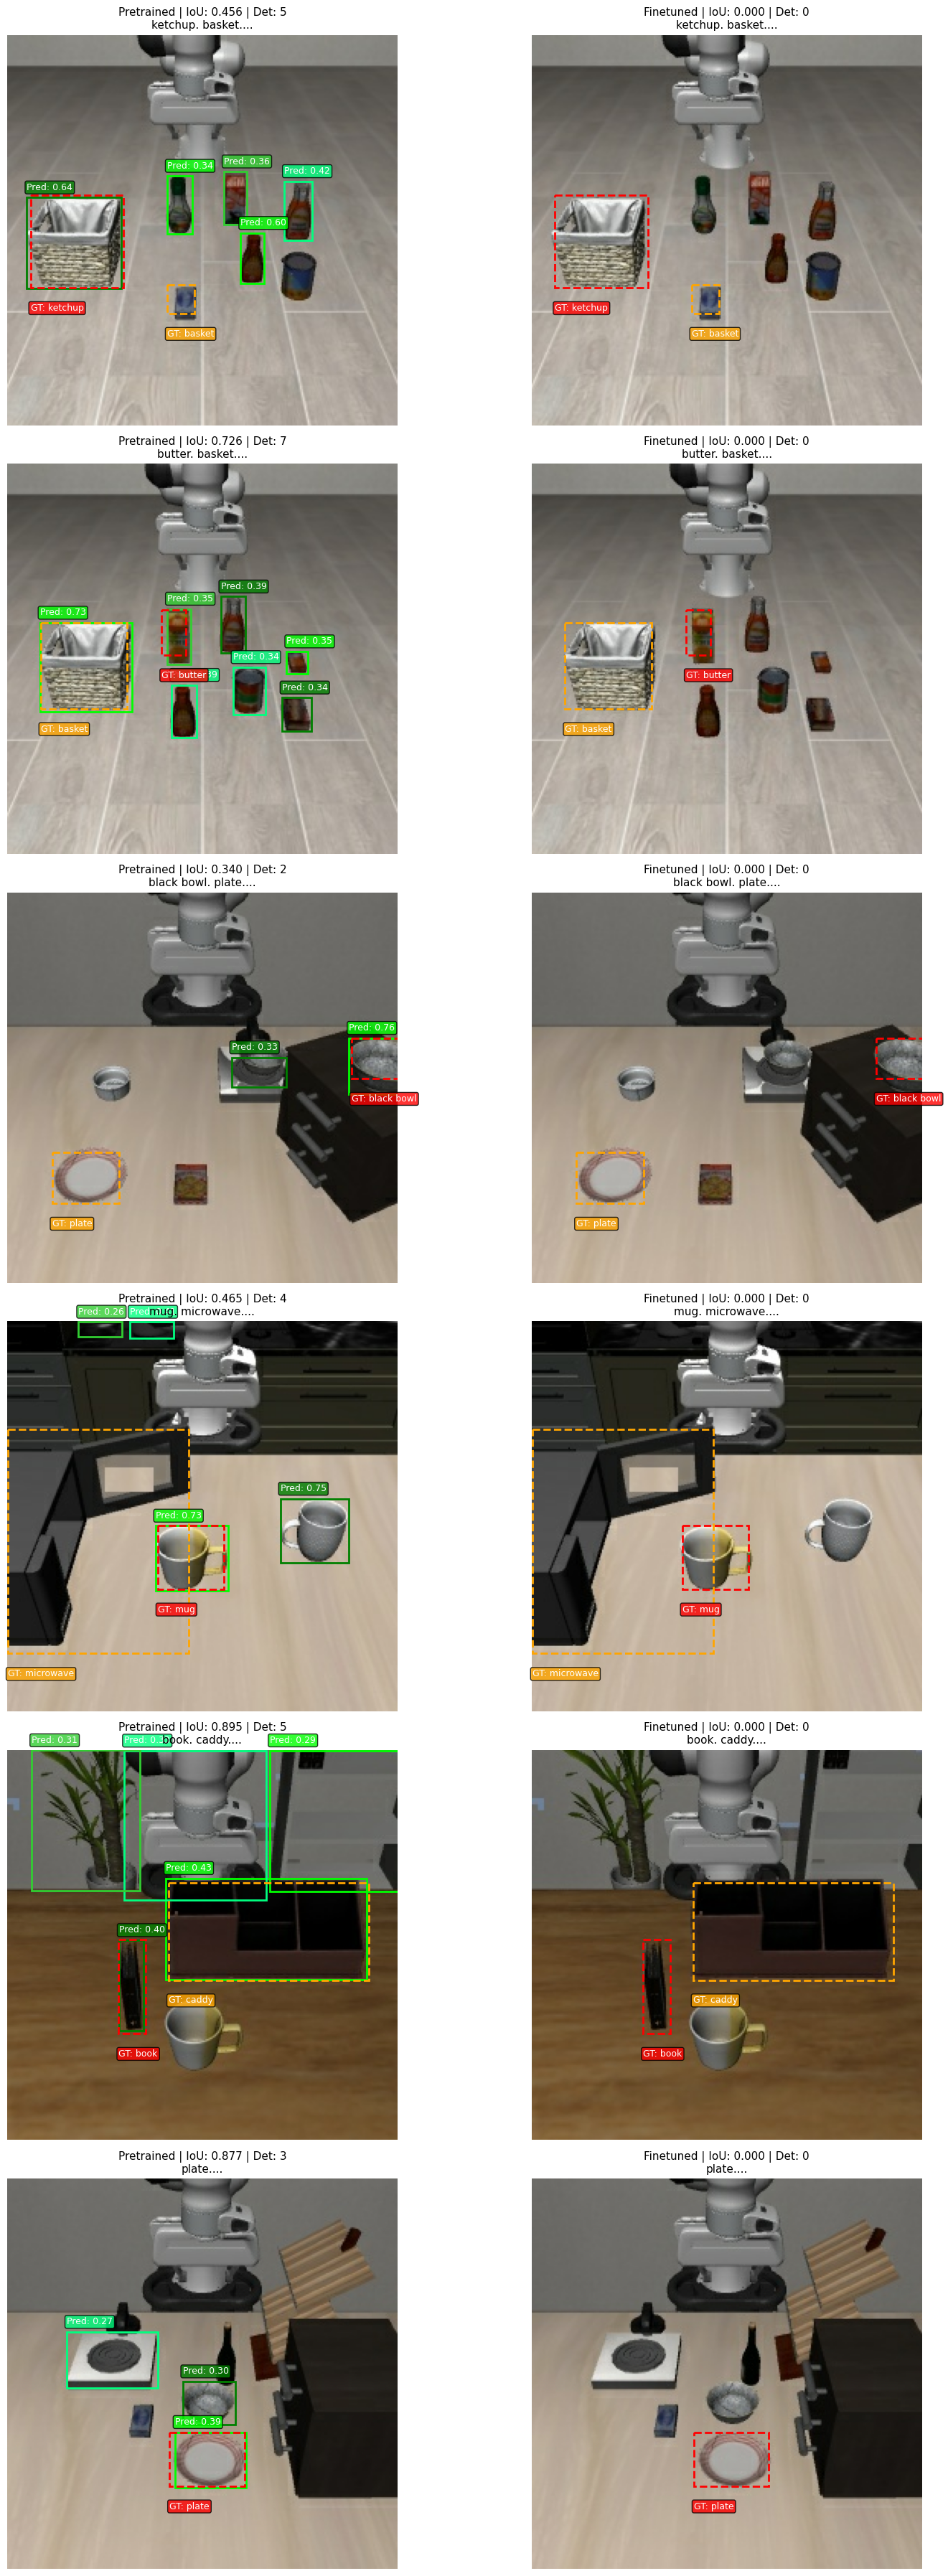


评估统计
Pretrained - 平均 IoU: 0.6267, 平均检测数: 4.33
Finetuned  - 平均 IoU: 0.0000, 平均检测数: 0.00

IoU 提升: -0.6267 (-100.0%)


In [25]:
# Cell 12: 执行评估

# 设置参数
NUM_SAMPLES = 6  # 可视化样本数量
BOX_THRESHOLD = 0.25  # 置信度阈值

# 检查模型是否加载
if model_pretrained is None and model_finetuned is None:
    print("错误: 没有加载任何模型！请确保权重文件存在。")
else:
    # 执行评估
    results = batch_evaluate_and_visualize(
        test_samples,
        model_pretrained,
        model_finetuned,
        DATASET_DIR,
        num_visualize=NUM_SAMPLES,
        box_threshold=BOX_THRESHOLD,
        device=DEVICE
    )


In [13]:
# Cell 13: 自定义测试 - 对单张图片进行测试

def test_single_image(
    image_path: str,
    caption: str,
    model: torch.nn.Module,
    box_threshold: float = 0.25,
    device: str = "cuda"
):
    """测试单张图片"""
    image = Image.open(image_path).convert('RGB')
    
    boxes, logits, phrases = run_inference(
        model, image, caption, box_threshold, device=device
    )
    
    print(f"检测到 {len(boxes)} 个目标")
    for i, (box, logit) in enumerate(zip(boxes, logits)):
        print(f"  [{i}] 置信度: {logit:.3f}, 位置: {box.tolist()}")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    visualize_predictions(
        image, boxes, logits, phrases,
        title=f"Caption: {caption}\nDetections: {len(boxes)}",
        ax=ax,
        show_gt=False
    )
    plt.show()


# 示例：测试单张图片
# test_image_path = DATASET_DIR / "images" / "episode_00000_frame_00000.jpg"
# test_caption = "bowl. drawer."
# 
# if test_image_path.exists() and model_finetuned is not None:
#     test_single_image(str(test_image_path), test_caption, model_finetuned, device=DEVICE)

print("自定义测试函数已定义，取消注释上面的代码即可使用")


自定义测试函数已定义，取消注释上面的代码即可使用



评估阈值: 0.1



评估阈值: 0.15

评估阈值: 0.2

评估阈值: 0.25

评估阈值: 0.3

评估阈值: 0.35

评估阈值: 0.4


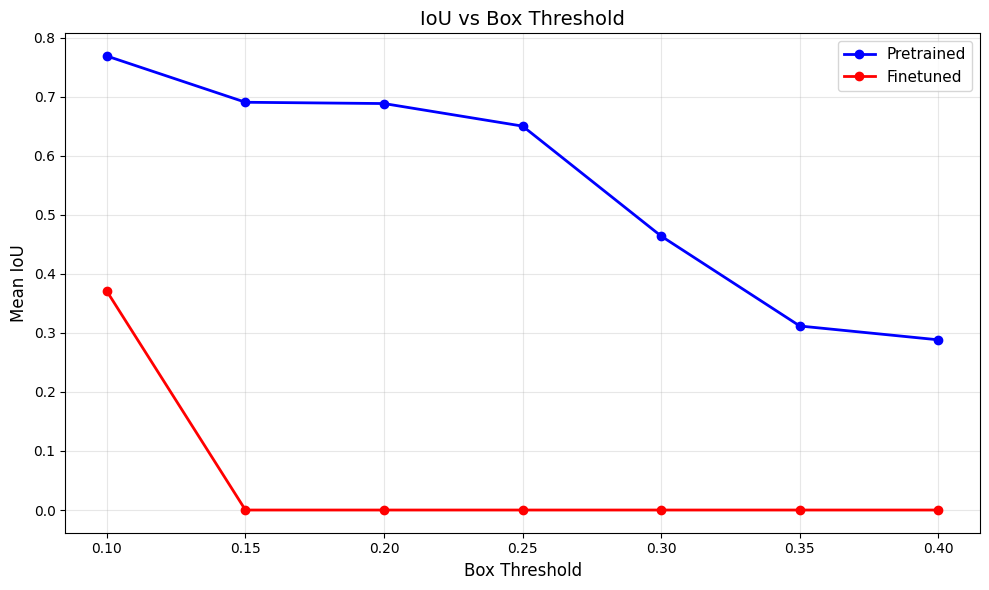

阈值分析函数已定义，取消注释上面的代码即可运行


In [14]:
# Cell 14: 不同阈值下的性能对比

def evaluate_across_thresholds(
    samples: List[Dict],
    model_pretrained: Optional[torch.nn.Module],
    model_finetuned: Optional[torch.nn.Module],
    dataset_dir: Path,
    thresholds: List[float] = [0.1, 0.2, 0.3, 0.4, 0.5],
    device: str = "cuda"
):
    """在不同阈值下评估模型性能"""
    results = {'pretrained': {}, 'finetuned': {}}
    
    for thresh in thresholds:
        print(f"\n评估阈值: {thresh}")
        
        ious_pre = []
        ious_ft = []
        
        for sample in samples:
            result = evaluate_sample(
                sample, model_pretrained, model_finetuned,
                dataset_dir, thresh, device
            )
            
            if 'pretrained' in result:
                ious_pre.append(result['pretrained']['iou'])
            if 'finetuned' in result:
                ious_ft.append(result['finetuned']['iou'])
        
        if ious_pre:
            results['pretrained'][thresh] = np.mean(ious_pre)
        if ious_ft:
            results['finetuned'][thresh] = np.mean(ious_ft)
    
    # 绘制曲线
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    if results['pretrained']:
        ax.plot(list(results['pretrained'].keys()), 
                list(results['pretrained'].values()), 
                'b-o', label='Pretrained', linewidth=2)
    
    if results['finetuned']:
        ax.plot(list(results['finetuned'].keys()), 
                list(results['finetuned'].values()), 
                'r-o', label='Finetuned', linewidth=2)
    
    ax.set_xlabel('Box Threshold', fontsize=12)
    ax.set_ylabel('Mean IoU', fontsize=12)
    ax.set_title('IoU vs Box Threshold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results


# 取消注释以运行阈值分析
threshold_results = evaluate_across_thresholds(
    test_samples[:10],
    model_pretrained,
    model_finetuned,
    DATASET_DIR,
    thresholds=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    device=DEVICE
)

print("阈值分析函数已定义，取消注释上面的代码即可运行")


In [ ]:
# Cell 15: 调试 - 检查模型输出的原始置信度

@torch.no_grad()
def debug_inference(
    model: torch.nn.Module,
    image: Image.Image,
    caption: str,
    device: str = "cuda"
):
    """调试推理 - 查看原始输出分布"""
    model.eval()
    
    # 预处理
    image_tensor = preprocess_image(image).to(device)
    
    # 确保 caption 格式正确
    if not caption.endswith('.'):
        caption = caption + '.'
    caption = caption.lower()
    
    print(f"Caption: {caption}")
    
    # 推理
    outputs = model(image_tensor.unsqueeze(0), captions=[caption])
    
    # 分析输出
    pred_logits = outputs['pred_logits'].sigmoid()[0]  # [num_queries, max_text_len]
    pred_boxes = outputs['pred_boxes'][0]  # [num_queries, 4]
    
    # 每个 query 的最大置信度
    max_logits = pred_logits.max(dim=-1).values  # [num_queries]
    
    print(f"\n=== 输出分析 ===")
    print(f"pred_logits shape: {pred_logits.shape}")
    print(f"pred_boxes shape: {pred_boxes.shape}")
    print(f"max_logits 范围: [{max_logits.min():.6f}, {max_logits.max():.6f}]")
    print(f"max_logits 均值: {max_logits.mean():.6f}")
    
    # Top-10 置信度
    top_k = 10
    topk_logits, topk_indices = max_logits.topk(min(top_k, len(max_logits)))
    print(f"\nTop-{top_k} 置信度:")
    for i, (logit, idx) in enumerate(zip(topk_logits, topk_indices)):
        box = pred_boxes[idx].tolist()
        print(f"  [{i}] 置信度: {logit:.6f}, bbox: [{box[0]:.3f}, {box[1]:.3f}, {box[2]:.3f}, {box[3]:.3f}]")
    
    # 统计不同阈值下的检测数量
    print(f"\n不同阈值下的检测数量:")
    for thresh in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        count = (max_logits > thresh).sum().item()
        print(f"  阈值 {thresh:.2f}: {count} 个检测")
    
    return outputs


# 测试第一个样本
sample = test_samples[0]
img_path = DATASET_DIR / sample['filename']
image = Image.open(img_path).convert('RGB')
caption = sample['grounding']['caption']

print("=" * 60)
print("预训练模型输出分析")
print("=" * 60)
_ = debug_inference(model_pretrained, image, caption, DEVICE)

print("\n" + "=" * 60)
print("微调模型输出分析")
print("=" * 60)
_ = debug_inference(model_finetuned, image, caption, DEVICE)


In [ ]:
# Cell 16: 检查模型权重是否正确加载

def check_model_weights(model, name="Model"):
    """检查模型权重统计"""
    print(f"\n=== {name} 权重统计 ===")
    
    total_params = 0
    nan_params = 0
    zero_params = 0
    
    for n, p in model.named_parameters():
        total_params += p.numel()
        nan_count = torch.isnan(p).sum().item()
        zero_count = (p == 0).sum().item()
        nan_params += nan_count
        zero_params += zero_count
        
        # 只打印有问题的层
        if nan_count > 0:
            print(f"  [NaN] {n}: {nan_count}/{p.numel()}")
    
    print(f"\n总参数: {total_params:,}")
    print(f"NaN 参数: {nan_params:,} ({nan_params/total_params*100:.4f}%)")
    print(f"零值参数: {zero_params:,} ({zero_params/total_params*100:.2f}%)")
    
    # 检查几个关键层的权重范围
    key_layers = ['transformer.decoder', 'bbox_embed', 'class_embed']
    print(f"\n关键层权重范围:")
    for n, p in model.named_parameters():
        for key in key_layers:
            if key in n and 'weight' in n:
                print(f"  {n}: [{p.min():.6f}, {p.max():.6f}], mean={p.mean():.6f}")
                break


print("预训练模型:")
check_model_weights(model_pretrained, "Pretrained")

print("\n" + "=" * 60)
print("\n微调模型:")
check_model_weights(model_finetuned, "Finetuned")


In [ ]:
# Cell 17: 改进的推理函数 - 正确匹配 phrase

from transformers import AutoTokenizer

# 加载 BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

@torch.no_grad()
def run_inference_with_phrases(
    model: torch.nn.Module,
    image: Image.Image,
    caption: str,
    box_threshold: float = 0.15,
    device: str = "cuda"
) -> Tuple[torch.Tensor, torch.Tensor, List[str]]:
    """
    推理并正确匹配每个 bbox 对应的 phrase
    
    Returns:
        (boxes, logits, phrases) - boxes 为 cxcywh 格式，phrases 是每个框对应的物体名称
    """
    model.eval()
    
    # 预处理
    image_tensor = preprocess_image(image).to(device)
    
    # 确保 caption 格式正确
    if not caption.endswith('.'):
        caption = caption + '.'
    caption_lower = caption.lower()
    
    # 解析 caption 中的 phrases (用 . 分隔)
    phrases_in_caption = [p.strip() for p in caption_lower.replace('.', ' . ').split('.') if p.strip()]
    
    # 获取每个 phrase 在 tokenized caption 中的位置
    tokenized = tokenizer(caption_lower, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
    
    # 找到每个 phrase 对应的 token 范围
    phrase_token_ranges = []
    for phrase in phrases_in_caption:
        phrase_tokens = tokenizer.tokenize(phrase)
        # 在 tokens 中找到这个 phrase
        for start_idx in range(len(tokens) - len(phrase_tokens) + 1):
            if tokens[start_idx:start_idx + len(phrase_tokens)] == phrase_tokens:
                phrase_token_ranges.append({
                    'phrase': phrase,
                    'start': start_idx,
                    'end': start_idx + len(phrase_tokens)
                })
                break
    
    # 推理
    outputs = model(image_tensor.unsqueeze(0), captions=[caption_lower])
    
    # 后处理
    pred_logits = outputs['pred_logits'].sigmoid()[0]  # [num_queries, max_text_len]
    pred_boxes = outputs['pred_boxes'][0]  # [num_queries, 4]
    
    # 获取每个 query 的最大置信度
    max_logits = pred_logits.max(dim=-1).values  # [num_queries]
    
    # 筛选高置信度的框
    mask = max_logits > box_threshold
    filtered_boxes = pred_boxes[mask]
    filtered_logits_all = pred_logits[mask]  # [num_filtered, max_text_len]
    filtered_max_logits = max_logits[mask]
    
    # 为每个检测框匹配最可能的 phrase
    matched_phrases = []
    for box_logits in filtered_logits_all:
        best_phrase = "unknown"
        best_score = 0
        
        for pr in phrase_token_ranges:
            # 计算这个 phrase 对应 token 位置的平均置信度
            start, end = pr['start'], pr['end']
            if end <= len(box_logits):
                score = box_logits[start:end].mean().item()
                if score > best_score:
                    best_score = score
                    best_phrase = pr['phrase']
        
        matched_phrases.append(best_phrase)
    
    return filtered_boxes.cpu(), filtered_max_logits.cpu(), matched_phrases


print("改进的推理函数定义完成")
print(f"Caption phrases 解析示例:")
test_caption = "ketchup. basket."
phrases = [p.strip() for p in test_caption.replace('.', ' . ').split('.') if p.strip()]
print(f"  '{test_caption}' -> {phrases}")


In [ ]:
# Cell 18: 使用改进的推理函数进行评估

def evaluate_with_phrase_matching(
    sample: Dict,
    model_pretrained: Optional[torch.nn.Module],
    model_finetuned: Optional[torch.nn.Module],
    dataset_dir: Path,
    box_threshold: float = 0.15,
    device: str = "cuda"
) -> Dict:
    """使用 phrase 匹配的评估函数"""
    # 加载图像
    img_path = dataset_dir / sample['filename']
    image = Image.open(img_path).convert('RGB')
    
    # 获取 GT
    caption = sample['grounding']['caption']
    regions = sample['grounding']['regions']
    
    # 转换 GT boxes: x1y1x2y2 -> cxcywh
    gt_boxes_cxcywh = []
    gt_labels = []
    for r in regions:
        x1, y1, x2, y2 = r['bbox']
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        gt_boxes_cxcywh.append([cx, cy, w, h])
        gt_labels.append(r['phrase'])
    gt_boxes = torch.tensor(gt_boxes_cxcywh)
    
    result = {
        'image': image,
        'caption': caption,
        'gt_boxes': gt_boxes,
        'gt_labels': gt_labels,
    }
    
    # 预训练模型推理
    if model_pretrained is not None:
        boxes_pre, logits_pre, phrases_pre = run_inference_with_phrases(
            model_pretrained, image, caption, box_threshold, device=device
        )
        iou_pre = compute_best_iou(boxes_pre, gt_boxes)
        result['pretrained'] = {
            'boxes': boxes_pre,
            'logits': logits_pre,
            'phrases': phrases_pre,
            'iou': iou_pre,
            'num_detections': len(boxes_pre)
        }
    
    # 微调模型推理
    if model_finetuned is not None:
        boxes_ft, logits_ft, phrases_ft = run_inference_with_phrases(
            model_finetuned, image, caption, box_threshold, device=device
        )
        iou_ft = compute_best_iou(boxes_ft, gt_boxes)
        result['finetuned'] = {
            'boxes': boxes_ft,
            'logits': logits_ft,
            'phrases': phrases_ft,
            'iou': iou_ft,
            'num_detections': len(boxes_ft)
        }
    
    return result


def visualize_with_phrases(
    image: Image.Image,
    boxes: torch.Tensor,
    logits: torch.Tensor,
    phrases: List[str],
    gt_boxes: Optional[torch.Tensor] = None,
    gt_labels: Optional[List[str]] = None,
    title: str = "",
    ax: Optional[plt.Axes] = None,
):
    """带 phrase 标注的可视化"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    ax.imshow(image)
    w, h = image.size
    
    # 绘制预测框 (绿色)
    pred_colors = ['lime', 'green', 'springgreen', 'limegreen', 'chartreuse']
    for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
        cx, cy, bw, bh = box.tolist()
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        box_w = bw * w
        box_h = bh * h
        
        color = pred_colors[i % len(pred_colors)]
        rect = patches.Rectangle(
            (x1, y1), box_w, box_h,
            linewidth=2, edgecolor=color, facecolor='none', linestyle='-'
        )
        ax.add_patch(rect)
        
        # 显示 phrase 和置信度
        label = f"{phrase}: {logit:.2f}"
        ax.text(x1, y1 - 5, label, color='white', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.8))
    
    # 绘制 GT 框 (红色虚线)
    if gt_boxes is not None:
        gt_colors = ['red', 'orange', 'coral', 'tomato', 'salmon']
        for i, box in enumerate(gt_boxes):
            cx, cy, bw, bh = box.tolist()
            x1 = (cx - bw / 2) * w
            y1 = (cy - bh / 2) * h
            box_w = bw * w
            box_h = bh * h
            
            color = gt_colors[i % len(gt_colors)]
            rect = patches.Rectangle(
                (x1, y1), box_w, box_h,
                linewidth=2, edgecolor=color, facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            
            if gt_labels and i < len(gt_labels):
                label = f"GT: {gt_labels[i]}"
                ax.text(x1, y1 + box_h + 15, label, color='white', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.8))
    
    ax.set_title(title, fontsize=11)
    ax.axis('off')


print("改进的评估函数定义完成")


In [ ]:
# Cell 19: 执行带 phrase 匹配的评估

NUM_SAMPLES = 4
BOX_THRESHOLD = 0.15  # 使用更低的阈值

print(f"使用阈值: {BOX_THRESHOLD}")
print("=" * 60)

# 评估几个样本
results = []
for i, sample in enumerate(test_samples[:NUM_SAMPLES]):
    result = evaluate_with_phrase_matching(
        sample, model_pretrained, model_finetuned,
        DATASET_DIR, BOX_THRESHOLD, DEVICE
    )
    results.append(result)
    
    print(f"\n[{i+1}/{NUM_SAMPLES}] {sample['filename']}")
    print(f"  Caption: {result['caption']}")
    print(f"  GT labels: {result['gt_labels']}")
    
    if 'pretrained' in result:
        pre = result['pretrained']
        print(f"  Pretrained: IoU={pre['iou']:.3f}, Det={pre['num_detections']}, Phrases={pre['phrases']}")
    
    if 'finetuned' in result:
        ft = result['finetuned']
        print(f"  Finetuned:  IoU={ft['iou']:.3f}, Det={ft['num_detections']}, Phrases={ft['phrases']}")

# 可视化
fig, axes = plt.subplots(NUM_SAMPLES, 2, figsize=(16, 6 * NUM_SAMPLES))

for i, result in enumerate(results):
    # 预训练模型
    if 'pretrained' in result:
        pre = result['pretrained']
        visualize_with_phrases(
            result['image'],
            pre['boxes'], pre['logits'], pre['phrases'],
            result['gt_boxes'], result['gt_labels'],
            title=f"Pretrained | IoU: {pre['iou']:.3f}\n{result['caption']}",
            ax=axes[i, 0]
        )
    
    # 微调模型
    if 'finetuned' in result:
        ft = result['finetuned']
        visualize_with_phrases(
            result['image'],
            ft['boxes'], ft['logits'], ft['phrases'],
            result['gt_boxes'], result['gt_labels'],
            title=f"Finetuned | IoU: {ft['iou']:.3f}\n{result['caption']}",
            ax=axes[i, 1]
        )

plt.tight_layout()
plt.show()

# 统计
print("\n" + "=" * 60)
print("统计结果")
print("=" * 60)

if model_pretrained:
    ious_pre = [r['pretrained']['iou'] for r in results if 'pretrained' in r]
    print(f"Pretrained - 平均 IoU: {np.mean(ious_pre):.4f}")

if model_finetuned:
    ious_ft = [r['finetuned']['iou'] for r in results if 'finetuned' in r]
    print(f"Finetuned  - 平均 IoU: {np.mean(ious_ft):.4f}")
